In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import glob
import random

In [3]:
RESERVED_SHOT = 114412  # Will be set randomly after valid_shots is created if None

# Define shot lists and paths
SHOT_PATHS = {
    'new_shots': {
        'range': (119591, 119769),
        'data_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Shots/',
        'hbt_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/python_hbteplib_data/',
        'ip_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/ip_Data/'
    },
    'old_shots': {
        'range': (114407, 114473),
        'data_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/Input Data/Old Shots/',
        'hbt_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/',
        'ip_path': '/Users/aboeckmann/Documents/Columbia/PlasmaLab/HBT-EP-Boeckmann/HighFreqMLModeling/Training/oldshot_python_hbteplib_data/'
    }
}

state = 2  # 1: new shots, 2: old shots, 3: combined
if state == 1:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
                 119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
                 119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
                 119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769]
elif state == 2:
    shot_list = [114407, 114408, 114411, 114412, 114413, 114415, 114416, 114417, 114418, 114419,
                 114420, 114422, 114424, 114425, 114428, 114429, 114431, 114432, 114433, 114434,
                 114435, 114436, 114438, 114439, 114441, 114443, 114444, 114445, 114448, 114450,
                 114451, 114453, 114454, 114455, 114456, 114457, 114458, 114460, 114462, 114464,
                 114467, 114468, 114472, 114473]
elif state == 3:
    shot_list = [119591, 119599, 119601, 119646, 119648, 119653, 119654, 119658, 119659,
                 119661, 119662, 119663, 119665, 119666, 119667, 119669, 119670, 119671,
                 119673, 119675, 119748, 119750, 119751, 119752, 119754, 119755, 119756,
                 119757, 119760, 119761, 119762, 119763, 119764, 119766, 119767, 119768, 119769,
                 114407, 114408, 114411, 114412, 114413, 114415, 114416, 114417, 114418, 114419,
                 114420, 114422, 114424, 114425, 114428, 114429, 114431, 114432, 114433, 114434,
                 114435, 114436, 114438, 114439, 114441, 114443, 114444, 114445, 114448, 114450,
                 114451, 114453, 114454, 114455, 114456, 114457, 114458, 114460, 114462, 114464,
                 114467, 114468, 114472, 114473]

CAMERA_DEPTH = 65535.0  # 2^16
DEFAULT_FRAME_COUNT = 800

def get_paths_for_shot(shot_num):
    """Return data, HBT, and IP paths for a given shot number."""
    for paths in SHOT_PATHS.values():
        if paths['range'][0] <= shot_num <= paths['range'][1]:
            return paths['data_path'], paths['hbt_path'], paths['ip_path']
    raise ValueError(f"Shot number {shot_num} is not in the defined ranges.")

In [4]:
def smooth_data(data, window_size=5):
    """Smooth data using a moving average with edge padding."""
    smoothed = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    pad = window_size // 2
    smoothed = np.pad(smoothed, (pad, pad), mode='edge')
    return smoothed[:len(data)]

def load_ip_data(shot_list):
    """Load IP data for given shots, handling missing files."""
    ip_data = []
    for shot in shot_list:
        _, _, ip_path = get_paths_for_shot(shot)
        try:
            ip_data.append(np.load(os.path.join(ip_path, f'{shot}ip.npy')))
        except FileNotFoundError:
            print(f"IP data file for shot {shot} not found. Skipping.")
    return ip_data

def format_ip_data(data, target_length=DEFAULT_FRAME_COUNT):
    """Format IP data to target length and shape."""
    data = np.asarray(data, dtype=float)
    frame_ratio = data[0].shape[0] // target_length
    return data[:, ::frame_ratio, np.newaxis][:,:target_length,:]

def find_initial_cutoff_index(ip_data, window_size=5, start_index=50):
    """Find initial cutoff index based on peak and valley detection."""
    smoothed_ip = smooth_data(ip_data, window_size)
    diff = np.diff(smoothed_ip)
    
    for i in range(start_index, len(diff)):
        if diff[i-1] > 0 and diff[i] < 0 and ip_data[i] > 0:
            peak_index = i
            for j in range(peak_index + 1, len(diff)):
                if diff[j-1] < 0 and diff[j] > 0 and ip_data[j] > 0:
                    return j
            return peak_index
    return 0

def find_end_cutoff_index(ip_data, window_size=5, jump_ratio=2.5, lookback_window=10, stability_window=30):
    """Find end cutoff index based on derivative jumps."""
    smoothed_ip = smooth_data(ip_data, window_size)
    diff = np.diff(smoothed_ip)
    
    baseline_median = np.median(diff[:stability_window]) if len(diff) > stability_window else np.median(diff)
    
    for i in range(stability_window, len(diff) - lookback_window):
        if np.max(diff[i:i + lookback_window]) > jump_ratio * abs(baseline_median) and diff[i] < 0.2 * np.max(diff[i:i + lookback_window]):
            return max(0, i - window_size)
    for i in range(stability_window, len(diff)):
        if diff[i] < -jump_ratio * abs(baseline_median):
            return max(0, i - window_size)
    return len(ip_data)

# Process IP data
ip_data = load_ip_data(shot_list)
formatted_ip_data = format_ip_data(ip_data)

initial_cutoff_indices = [find_initial_cutoff_index(formatted_ip_data[i, :, 0]) for i in range(len(shot_list))]
end_cutoff_indices = [
    find_end_cutoff_index(formatted_ip_data[i, initial_cutoff_indices[i]:, 0]) + initial_cutoff_indices[i]
    if find_end_cutoff_index(formatted_ip_data[i, initial_cutoff_indices[i]:, 0]) < len(formatted_ip_data[i, initial_cutoff_indices[i]:, 0])
    else DEFAULT_FRAME_COUNT
    for i in range(len(shot_list))
]
frame_counts = [end - start for end, start in zip(end_cutoff_indices, initial_cutoff_indices)]

In [5]:
def process_shot_data(folder_path, initial_cutoff, end_cutoff, max_pixel_value=CAMERA_DEPTH):
    """Process TIFF images in a folder, cropping to 32x32 and normalizing."""
    tiff_files = sorted(glob.glob(os.path.join(folder_path, "*.tiff")))
    if not tiff_files:
        raise ValueError(f"No TIFF files found in {folder_path}")
    
    end_cutoff = min(end_cutoff, len(tiff_files))
    if initial_cutoff >= end_cutoff:
        raise ValueError(f"Invalid cutoff indices: initial={initial_cutoff}, end={end_cutoff}")
    
    shot_2d = []
    for tiff_file in tiff_files[initial_cutoff:end_cutoff]:
        try:
            with Image.open(tiff_file) as im:
                img = np.array(im, dtype=np.float32) / max_pixel_value
                h, w = img.shape
                if h < 32 or w < 32:
                    raise ValueError(f"Image too small to crop to 32x32: got {h}x{w}")
                
                start_h, start_w = (h - 32) // 2, (w - 32) // 2
                cropped = img[start_h:start_h + 32, start_w:start_w + 32]
                shot_2d.append(cropped)
        except Exception as e:
            print(f"Error loading {tiff_file}: {e}")
            continue
    
    if not shot_2d:
        raise ValueError(f"No valid frames processed for {folder_path}")
    
    shot_2d = np.array(shot_2d)
    return shot_2d, shot_2d, shot_2d.reshape(len(shot_2d), -1), len(shot_2d)

def process_all_shots(shot_list, initial_cutoff_indices, end_cutoff_indices, frame_counts):
    """Process all shots, returning 2D, cut, flat data, valid shots, and frame counts."""
    training_data_2D, cut_training_data_2D, flat_training_data = [], [], []
    valid_shots, actual_frame_counts = [], []
    
    for i, shot in enumerate(shot_list):
        data_path, _, _ = get_paths_for_shot(shot)
        folder_path = os.path.join(data_path, str(shot), 'CAM-26731/tiff/')
        try:
            shot_2d, cut_2d, flat_data, actual_frames = process_shot_data(
                folder_path, initial_cutoff_indices[i], end_cutoff_indices[i]
            )
            if actual_frames > 0:
                training_data_2D.append(shot_2d)
                cut_training_data_2D.append(cut_2d)
                flat_training_data.append(flat_data)
                valid_shots.append(shot)
                actual_frame_counts.append(actual_frames)
            else:
                print(f"Shot {shot} produced 0 frames. Skipping.")
        except Exception as e:
            print(f"Error processing shot {shot}: {e}")
    
    return training_data_2D, cut_training_data_2D, flat_training_data, valid_shots, actual_frame_counts

# Process all shots
training_data_2D, cut_training_data_2D, flat_training_data, valid_shots, actual_frame_counts = process_all_shots(
    shot_list, initial_cutoff_indices, end_cutoff_indices, frame_counts
)

# Set RESERVED_SHOT randomly if not specified
if RESERVED_SHOT is None:
    random.seed(123)  # For reproducibility
    RESERVED_SHOT = random.choice(valid_shots)
    print(f"Randomly selected reserved shot: {RESERVED_SHOT}")
elif RESERVED_SHOT not in valid_shots:
    raise ValueError(f"Specified RESERVED_SHOT {RESERVED_SHOT} is not in valid_shots.")

def format_hbt_data(data, mode_num, initial_cutoffs, end_cutoffs):
    """Format HBT data for a given mode, trimming to cutoff indices."""
    return [
        data[shot_list.index(shot)][mode_num-1][initial_cutoffs[shot_list.index(shot)]:end_cutoffs[shot_list.index(shot)]].reshape(-1, 1)
        for shot in valid_shots
    ]

In [6]:
def load_hbt_data(shot_list, valid_shots, initial_cutoffs, end_cutoffs):
    """Load and format HBT amplitude, phase, and time data."""
    hbt_data = {'amplitudes': [], 'phases': [], 'times': []}
    
    for shot in shot_list:
        _, hbt_path, _ = get_paths_for_shot(shot)
        modes = {
            f'mode_{m}': {
                'amp': np.load(os.path.join(hbt_path, f'{shot}m{m}Amp.npy')),
                'phase': np.load(os.path.join(hbt_path, f'{shot}m{m}Phase.npy'))
            } for m in range(1, 5)
        }
        hbt_data['amplitudes'].append([modes[f'mode_{m}']['amp'] for m in range(1, 5)])
        hbt_data['phases'].append([modes[f'mode_{m}']['phase'] for m in range(1, 5)])
        hbt_data['times'].append(np.load(os.path.join(hbt_path, f'{shot}time.npy')))
    
    # Format data
    formatted_data = {
        'amplitudes': [format_hbt_data(hbt_data['amplitudes'], m, initial_cutoffs, end_cutoffs) for m in range(1, 5)],
        'phases': [format_hbt_data(hbt_data['phases'], m, initial_cutoffs, end_cutoffs) for m in range(1, 5)],
        'times': [
            hbt_data['times'][shot_list.index(shot)][initial_cutoffs[shot_list.index(shot)]:end_cutoffs[shot_list.index(shot)]]
            for shot in valid_shots
        ]
    }
    
    print("HBT data shapes:")
    print(f"Mode amplitude 1: {len(formatted_data['amplitudes'][0])} shots with variable frame counts")
    print(f"Mode phase 1: {len(formatted_data['phases'][0])} shots with variable frame counts")
    print(f"Time data: {len(formatted_data['times'])} shots with variable frame counts")
    print("\nFrame counts per shot:")
    for i, shot in enumerate(valid_shots):
        frame_count = len(formatted_data['times'][i])
        print(f"Shot {shot}: {frame_count} frames")
    
    return formatted_data
    
    return formatted_data

# Load and format HBT data
hbt_data = load_hbt_data(shot_list, valid_shots, initial_cutoff_indices, end_cutoff_indices)
hbt_ma1_data, hbt_ma2_data, hbt_ma3_data, hbt_ma4_data = hbt_data['amplitudes']
hbt_mp1_data, hbt_mp2_data, hbt_mp3_data, hbt_mp4_data = hbt_data['phases']
hbt_time_data = hbt_data['times']

HBT data shapes:
Mode amplitude 1: 44 shots with variable frame counts
Mode phase 1: 44 shots with variable frame counts
Time data: 44 shots with variable frame counts

Frame counts per shot:
Shot 114407: 496 frames
Shot 114408: 652 frames
Shot 114411: 615 frames
Shot 114412: 634 frames
Shot 114413: 670 frames
Shot 114415: 677 frames
Shot 114416: 687 frames
Shot 114417: 663 frames
Shot 114418: 709 frames
Shot 114419: 699 frames
Shot 114420: 707 frames
Shot 114422: 708 frames
Shot 114424: 659 frames
Shot 114425: 648 frames
Shot 114428: 662 frames
Shot 114429: 683 frames
Shot 114431: 708 frames
Shot 114432: 708 frames
Shot 114433: 681 frames
Shot 114434: 669 frames
Shot 114435: 684 frames
Shot 114436: 708 frames
Shot 114438: 685 frames
Shot 114439: 694 frames
Shot 114441: 688 frames
Shot 114443: 681 frames
Shot 114444: 708 frames
Shot 114445: 698 frames
Shot 114448: 689 frames
Shot 114450: 696 frames
Shot 114451: 646 frames
Shot 114453: 690 frames
Shot 114454: 669 frames
Shot 114455: 692

Normalization factor (99th percentile): 1.11
Number of outliers (|value| > 3.33): 57
Training shape: (28722, 32, 32, 1) Target shape: (28722,)
Testing shape: (400, 32, 32, 1) Testing label shape: (400,)


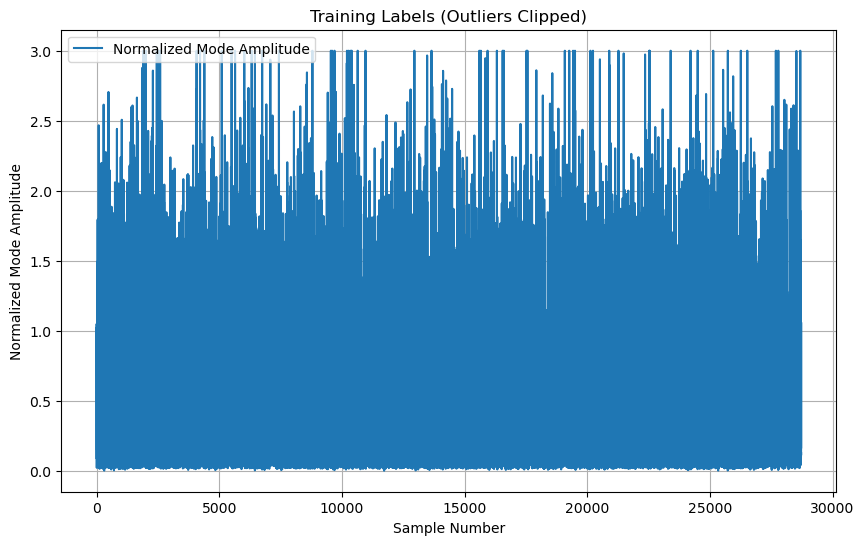

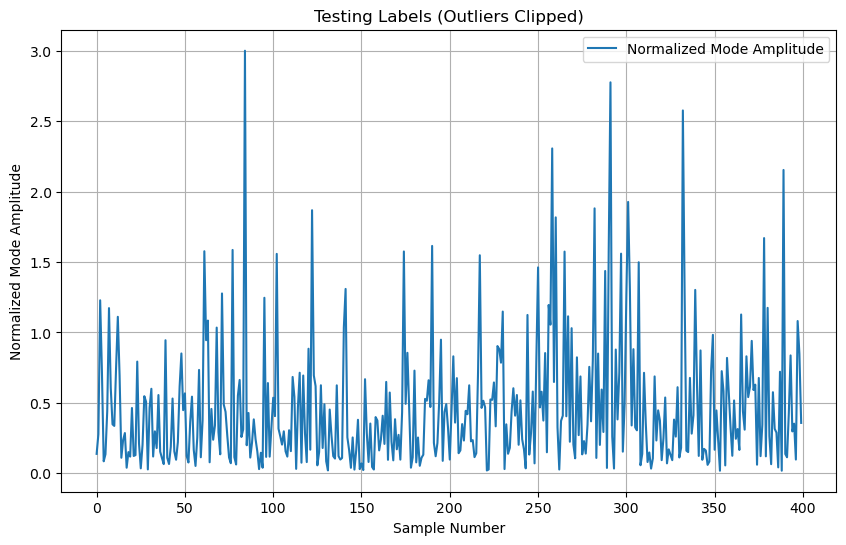

In [7]:
# Prepare data for HBT prediction model
target_data = hbt_ma2_data  # Using mode 2 amplitude as target
training_data = cut_training_data_2D

# Normalization factors
camera_norm = 1  # Camera data already normalized by max_pixel_value
# Use percentile-based normalization to handle outliers
raw_target_vector = []
for i, shot in enumerate(valid_shots):
    if shot == RESERVED_SHOT:
        continue
    shot_idx = shot_list.index(shot)
    for j in range(actual_frame_counts[i]):
        raw_target_vector.append(target_data[shot_idx][j])

# Convert to numpy array for analysis
raw_target_vector = np.asarray(raw_target_vector, dtype=np.float32)[:, 0]

# Check for outliers
percentile_99 = np.percentile(np.abs(raw_target_vector), 90)
ma_norm = percentile_99 if percentile_99 > 0 else 1.0  # Use 99th percentile for normalization
outlier_threshold = 3 * ma_norm  # Define outliers as values > 3 * normalization factor
outliers = np.abs(raw_target_vector) > outlier_threshold
print(f"Normalization factor (99th percentile): {ma_norm:.2f}")
print(f"Number of outliers (|value| > {outlier_threshold:.2f}): {np.sum(outliers)}")

# Clip outliers for normalization
raw_target_vector = np.clip(raw_target_vector, -outlier_threshold, outlier_threshold)

# Reshape the training data and labels, excluding RESERVED_SHOT
target_vector = []
training_vector = []
for i, shot in enumerate(valid_shots):
    if shot == RESERVED_SHOT:
        continue
    shot_idx = shot_list.index(shot)
    for j in range(actual_frame_counts[i]):
        target_vector.append(target_data[shot_idx][j])
        training_vector.append(training_data[i][j])

# Shuffle the data
random.seed(123)
zip_list = list(zip(target_vector, training_vector))
random.shuffle(zip_list)
target_vector, training_vector = zip(*zip_list)

# Convert to numpy arrays and normalize with clipping
target_vector = np.asarray(target_vector, dtype=np.float32)[:, 0]
target_vector = np.clip(target_vector, -outlier_threshold, outlier_threshold) / ma_norm
training_vector = np.asarray(training_vector, dtype=np.float32).reshape(-1, 32, 32, 1)

# Split into training and testing sets
test_size = 400
testing_inputs = training_vector[-test_size:]
testing_labels = target_vector[-test_size:]
training_vector = training_vector[:-test_size]
target_vector = target_vector[:-test_size]

print('Training shape:', training_vector.shape, 'Target shape:', target_vector.shape)
print('Testing shape:', testing_inputs.shape, 'Testing label shape:', testing_labels.shape)

# Plot training labels
plt.figure(figsize=(10, 6))
plt.plot(target_vector, label='Normalized Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('Training Labels (Outliers Clipped)')
plt.grid(True)
plt.legend()
plt.show()

# Plot testing labels
plt.figure(figsize=(10, 6))
plt.plot(testing_labels, label='Normalized Mode Amplitude')
plt.xlabel('Sample Number')
plt.ylabel('Normalized Mode Amplitude')
plt.title('Testing Labels (Outliers Clipped)')
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Define model architecture
num_conv2d_layers = 3
num_dense_layers = 2

conv2d_neurons = [32, 32, 16]  # Increased filters
conv2d_size = [(8, 8), (4, 4), (4, 4)]  # Adjusted kernel sizes
dense_layer_neurons = [64, 32]  # Increased neurons
max_pooling_size = (2, 2)  # Smaller pooling to retain more spatial info
activation_func = 'relu'
loss_func = 'mean_squared_error'
optimizer_func = 'adam'

# Create the model
william_model = tf.keras.models.Sequential()

# Add input layer
william_model.add(tf.keras.layers.InputLayer(shape=(32, 32, 1)))

# Add Conv2D layers
for i in range(num_conv2d_layers):
    william_model.add(tf.keras.layers.Conv2D(conv2d_neurons[i], conv2d_size[i], padding='same', activation=activation_func))
    william_model.add(tf.keras.layers.MaxPooling2D(max_pooling_size, padding='same'))

# Flatten the output
william_model.add(tf.keras.layers.Flatten())

# Add dense layers
for i in range(num_dense_layers):
    william_model.add(tf.keras.layers.Dense(dense_layer_neurons[i], activation=activation_func))
    william_model.add(tf.keras.layers.Dropout(0.2))  # Add dropout to prevent overfitting

# Output layer
william_model.add(tf.keras.layers.Dense(1))

# Compile the model
william_model.compile(optimizer=optimizer_func, loss=loss_func)

# Display model summary
william_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,265 (176.82 KB)

 Trainable params: 45,265 (176.82 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Train the model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
Model = william_model
history = Model.fit(training_vector, target_vector,
                    epochs=50,
                    validation_split=0.2,
                    batch_size=32,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2046 - val_loss: 0.1632
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1658 - val_loss: 0.1803
Epoch 3/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1674 - val_loss: 0.1524
Epoch 4/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1599 - val_loss: 0.1440
Epoch 5/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1519 - val_loss: 0.1499
Epoch 6/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1544 - val_loss: 0.1434
Epoch 7/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1493 - val_loss: 0.1385
Epoch 8/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1471 - val_loss: 0.1543
Epoch 9/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1456 - val_loss: 0.1392
Epoch 10/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1445 - val_loss: 0.1629
Epoch 11/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1460 - val_loss: 0.1326
Epoch 12/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 1

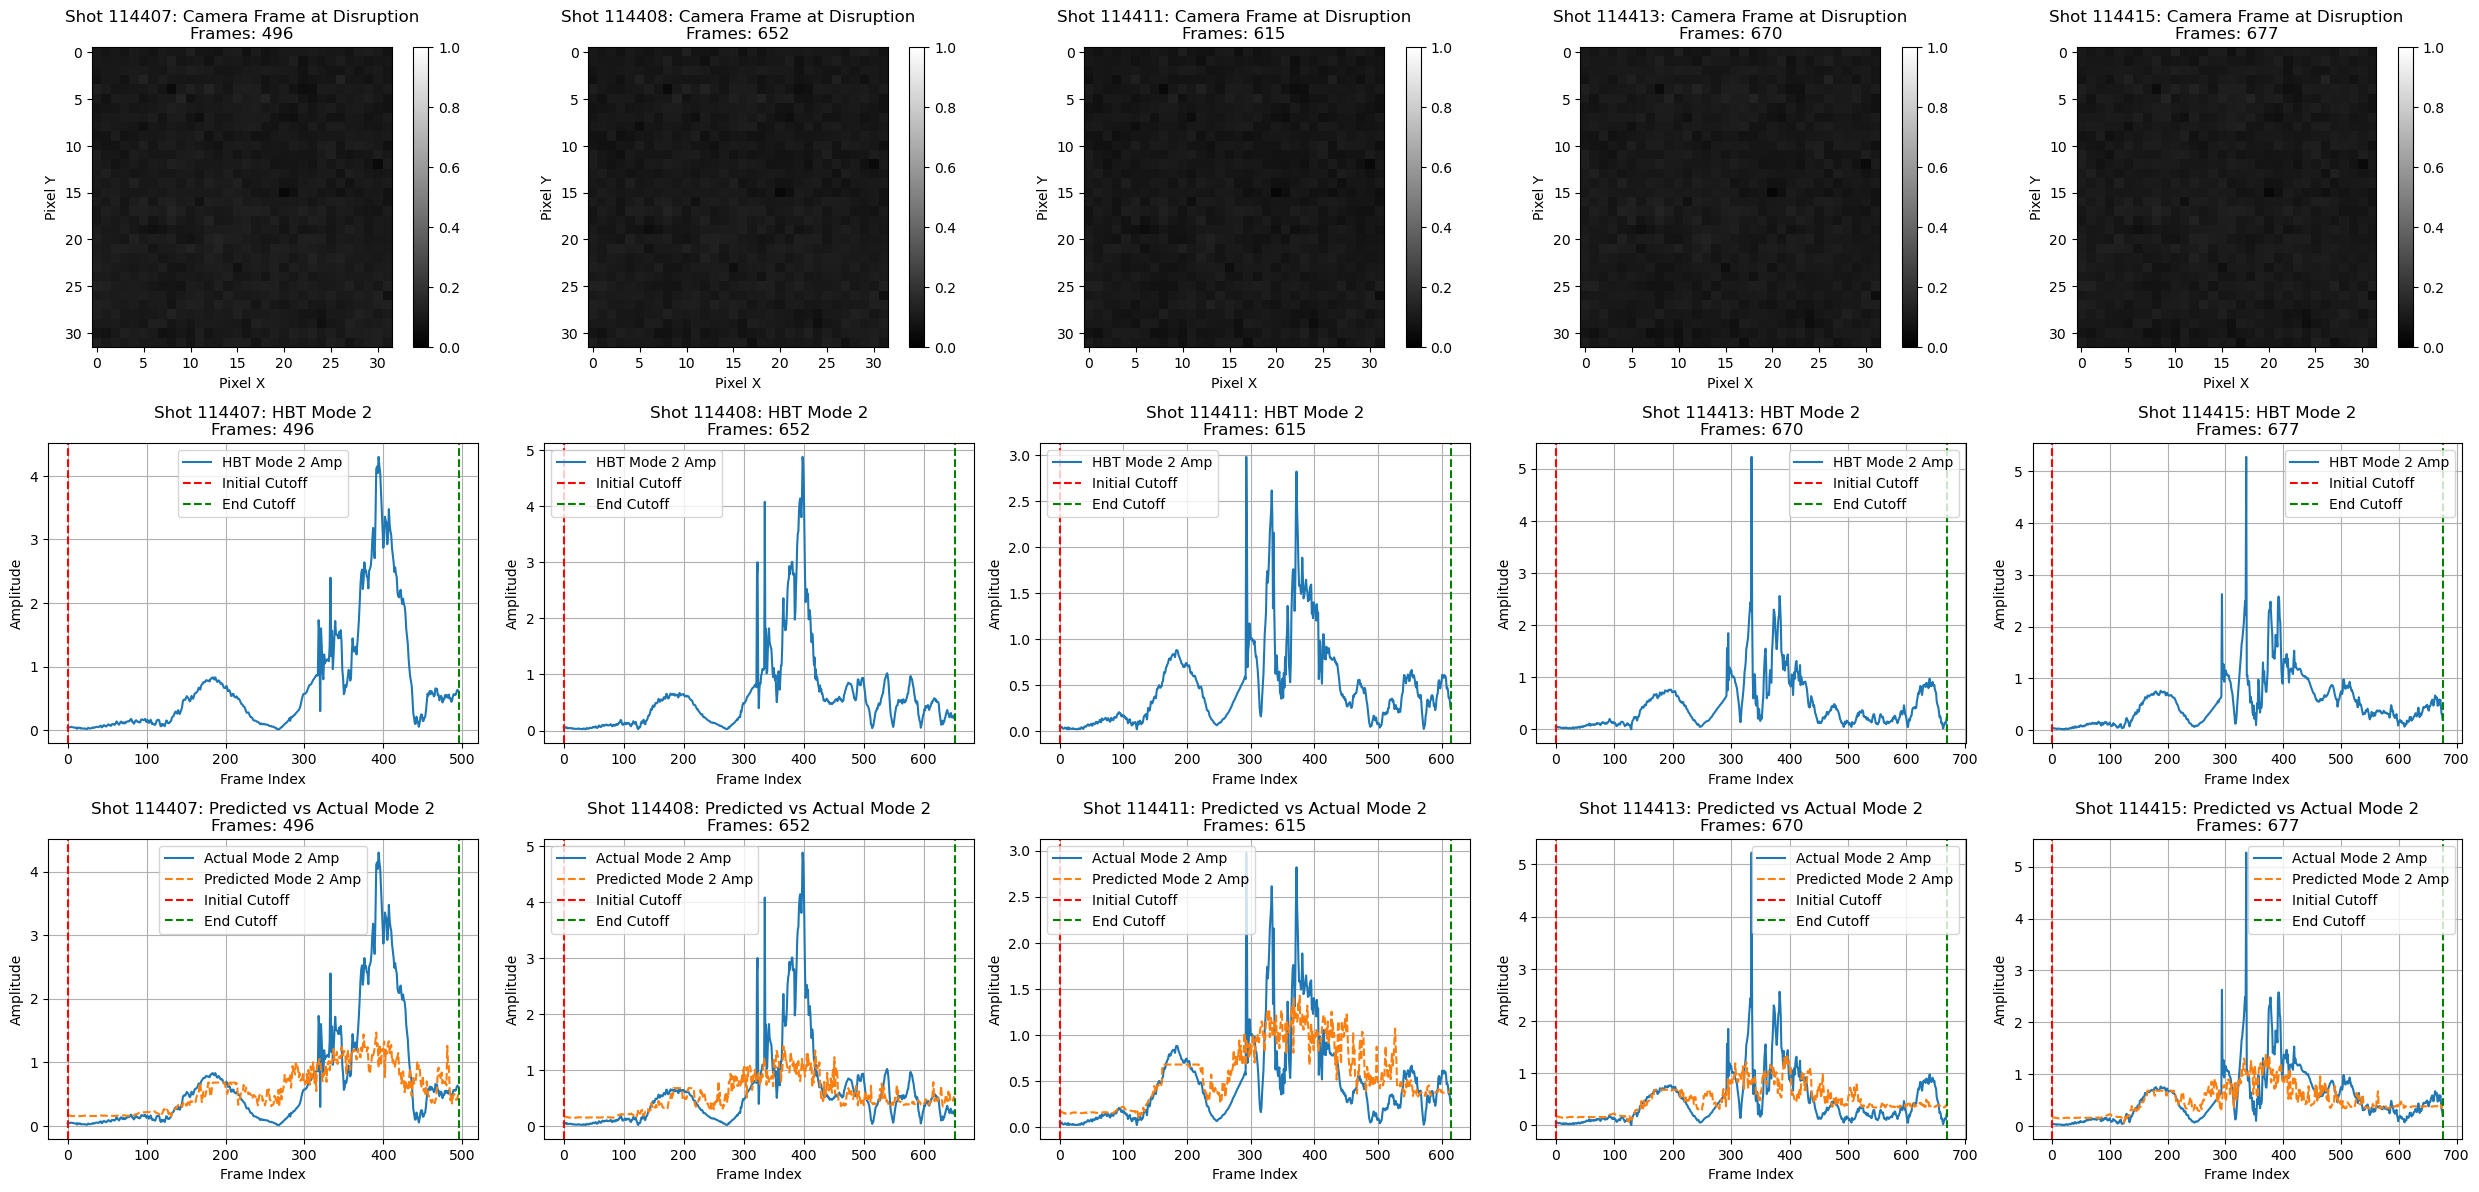

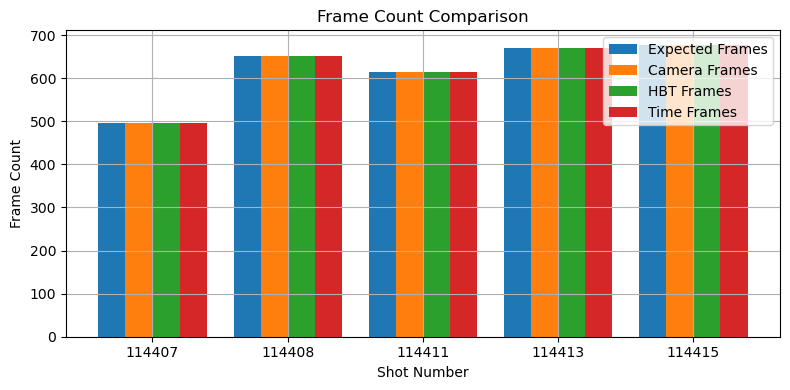

In [25]:
def visualize_non_ip_data(shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, hbt_time_data, 
                          initial_cutoff_indices, end_cutoff_indices, actual_frame_counts, num_shots_to_plot, model, ma_norm=5):
    """
    Visualize camera, HBT mode amplitude, and predicted mode amplitude with cutoff indices for debugging.
    """
    # Select a few shots to visualize, excluding RESERVED_SHOT
    shots_to_plot = [shot for shot in valid_shots if shot != RESERVED_SHOT][:min(num_shots_to_plot, len(valid_shots)-1)]
    
    # Create figure for camera, HBT, and predicted mode amplitude data
    fig, axes = plt.subplots(3, len(shots_to_plot), figsize=(5 * len(shots_to_plot), 12))
    if len(shots_to_plot) == 1:
        axes = np.array([axes]).T  # Ensure 2D indexing
    
    for col, shot in enumerate(shots_to_plot):
        shot_idx = shot_list.index(shot)
        initial_idx = initial_cutoff_indices[shot_idx]
        end_idx = end_cutoff_indices[shot_idx]
        frame_count = actual_frame_counts[valid_shots.index(shot)]
        
        # Plot 1: Camera data (frame at disruption point)
        camera_data = cut_training_data_2D[valid_shots.index(shot)]
        if len(camera_data) > 0:
            disruption_frame = camera_data[-1]  # Last frame (disruption point)
            im = axes[0, col].imshow(disruption_frame, cmap='gray', vmin=0, vmax=1)
            plt.colorbar(im, ax=axes[0, col])
            axes[0, col].set_title(f'Shot {shot}: Camera Frame at Disruption\nFrames: {len(camera_data)}')
            axes[0, col].set_xlabel('Pixel X')
            axes[0, col].set_ylabel('Pixel Y')
        else:
            axes[0, col].text(0.5, 0.5, 'No Camera Data', ha='center', va='center')
            axes[0, col].set_title(f'Shot {shot}: Camera Frame at Disruption\nFrames: 0')
        
        # Plot 2: HBT Mode 2 Amplitude
        hbt_data = hbt_ma2_data[valid_shots.index(shot)][:, 0]
        axes[1, col].plot(hbt_data, label='HBT Mode 2 Amp')
        axes[1, col].axvline(x=0, color='r', linestyle='--', label='Initial Cutoff')
        axes[1, col].axvline(x=end_idx - initial_idx, color='g', linestyle='--', label='End Cutoff')
        axes[1, col].set_title(f'Shot {shot}: HBT Mode 2\nFrames: {len(hbt_data)}')
        axes[1, col].set_xlabel('Frame Index')
        axes[1, col].set_ylabel('Amplitude')
        axes[1, col].legend()
        axes[1, col].grid(True)
        
        # Plot 3: Predicted vs Actual Mode 2 Amplitude
        if len(camera_data) > 0:
            # Prepare camera data for prediction
            input_data = np.array(camera_data).reshape(-1, 32, 32, 1)
            predictions = model.predict(input_data, verbose=0) * ma_norm  # Scale back to original units
            axes[2, col].plot(hbt_data, label='Actual Mode 2 Amp')
            axes[2, col].plot(predictions[:, 0], '--', label='Predicted Mode 2 Amp')
            axes[2, col].axvline(x=0, color='r', linestyle='--', label='Initial Cutoff')
            axes[2, col].axvline(x=end_idx - initial_idx, color='g', linestyle='--', label='End Cutoff')
            axes[2, col].set_title(f'Shot {shot}: Predicted vs Actual Mode 2\nFrames: {len(hbt_data)}')
            axes[2, col].set_xlabel('Frame Index')
            axes[2, col].set_ylabel('Amplitude')
            axes[2, col].legend()
            axes[2, col].grid(True)
        else:
            axes[2, col].text(0.5, 0.5, 'No Prediction Data', ha='center', va='center')
            axes[2, col].set_title(f'Shot {shot}: Predicted vs Actual Mode 2\nFrames: 0')
    
    plt.tight_layout()
    
    # Summary plot: Frame counts across datasets
    plt.figure(figsize=(8, 4))
    shot_indices = [shot_list.index(shot) for shot in shots_to_plot]
    expected_frames = [end_cutoff_indices[i] - initial_cutoff_indices[i] for i in shot_indices]
    camera_frames = [len(cut_training_data_2D[valid_shots.index(shot)]) for shot in shots_to_plot]
    hbt_frames = [len(hbt_ma2_data[valid_shots.index(shot)]) for shot in shots_to_plot]
    time_frames = [len(hbt_time_data[valid_shots.index(shot)]) for shot in shots_to_plot]
    
    x = np.arange(len(shots_to_plot))
    width = 0.2
    plt.bar(x - 1.5 * width, expected_frames, width, label='Expected Frames')
    plt.bar(x - 0.5 * width, camera_frames, width, label='Camera Frames')
    plt.bar(x + 0.5 * width, hbt_frames, width, label='HBT Frames')
    plt.bar(x + 1.5 * width, time_frames, width, label='Time Frames')
    plt.xticks(x, shots_to_plot)
    plt.xlabel('Shot Number')
    plt.ylabel('Frame Count')
    plt.title('Frame Count Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()

visualize_non_ip_data(
    shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, hbt_time_data,
    initial_cutoff_indices, end_cutoff_indices, actual_frame_counts, num_shots_to_plot=5,
    model=william_model, ma_norm=ma_norm
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


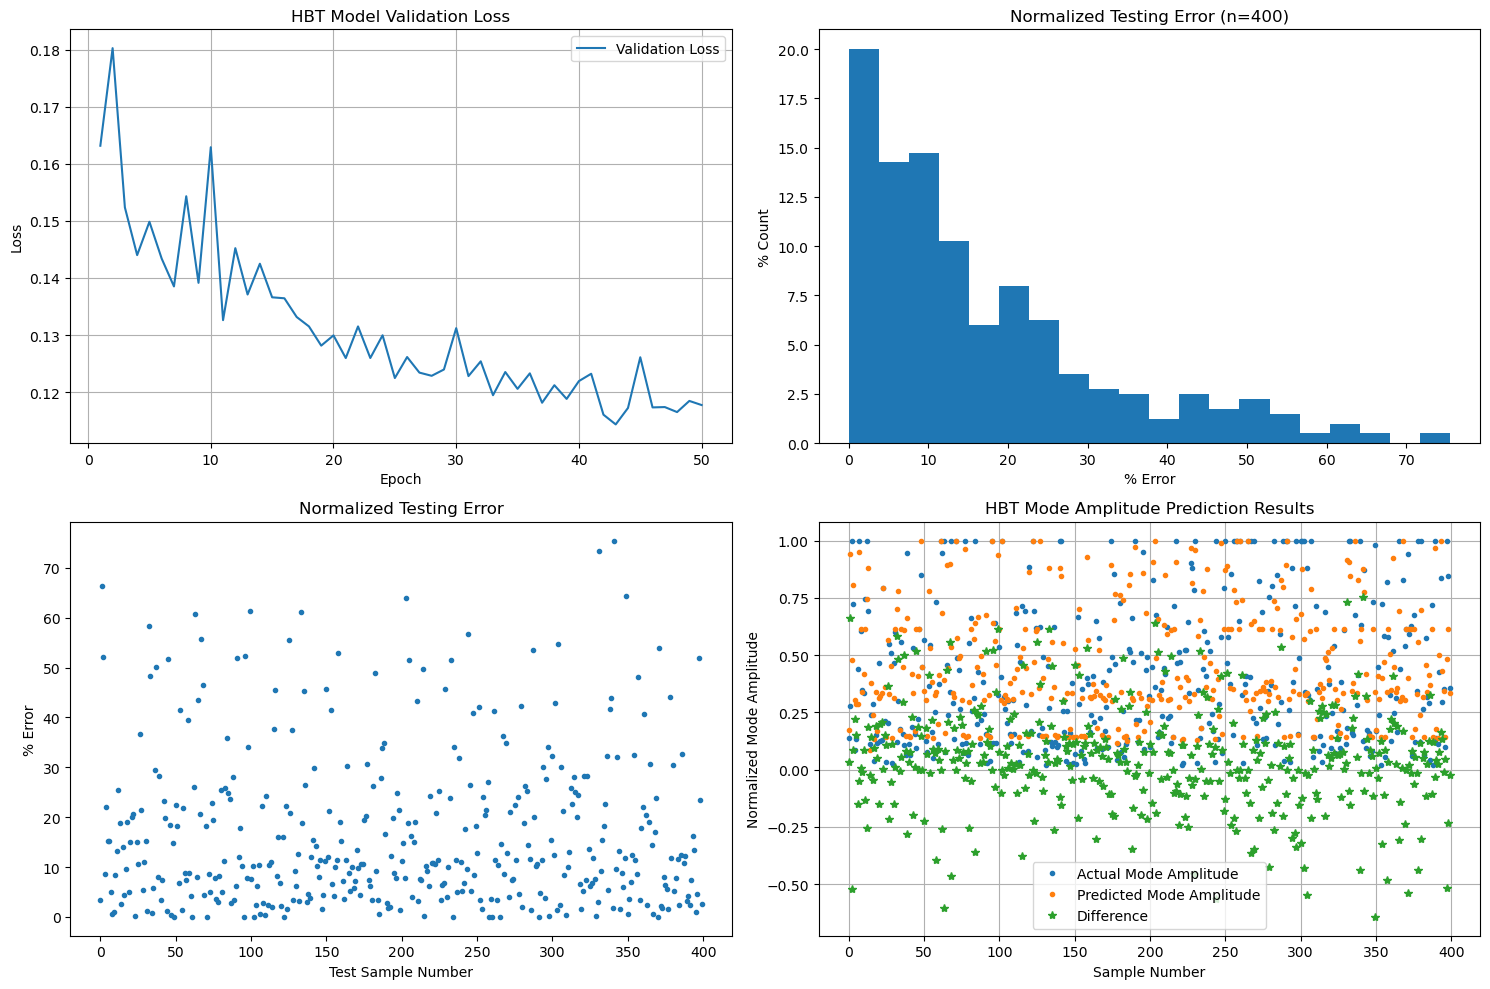

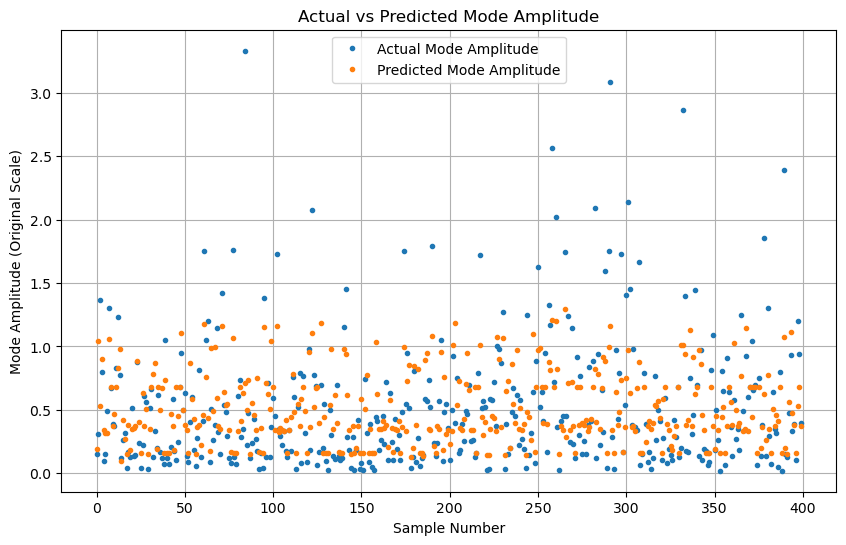

Maximum actual mode amplitude (normalized): 3.00
Maximum predicted mode amplitude (normalized): 1.17
Mean absolute percentage error: 16.82%


In [27]:
def plot_model_results(history, testing_labels, predictions, ma_norm=1.0):
    """Plot model training history, error distribution, and predictions."""
    # Normalize data
    norm_labels = np.clip(testing_labels, -1, 1)  # Already normalized, just ensure clipping
    norm_preds = np.clip(predictions[:, 0], -1, 1)
    prediction_errors = np.abs(norm_labels - norm_preds) * 100
    
    # Create figure with subplots
    fig, axes = plt.subplots(figsize=(15, 10), ncols=2, nrows=2)
    axes = axes.flatten()
    
    # Plot 1: Validation Loss
    axes[0].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('HBT Model Validation Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Error Distribution
    weights = np.ones_like(prediction_errors) / len(prediction_errors) * 100
    axes[1].hist(prediction_errors, 20, weights=weights)
    axes[1].set_xlabel('% Error')
    axes[1].set_ylabel('% Count')
    axes[1].set_title('Normalized Testing Error (n=400)')
    
    # Plot 3: Error by Sample
    axes[2].plot(prediction_errors, '.')
    axes[2].set_xlabel('Test Sample Number')  
    axes[2].set_ylabel('% Error')
    axes[2].set_title('Normalized Testing Error')
    
    # Plot 4: Actual vs Predicted
    axes[3].plot(norm_labels, '.', label='Actual Mode Amplitude')
    axes[3].plot(norm_preds, '.', label='Predicted Mode Amplitude')
    axes[3].plot(-(norm_labels - norm_preds), '*', label='Difference')
    axes[3].set_xlabel('Sample Number')
    axes[3].set_ylabel('Normalized Mode Amplitude')
    axes[3].set_title('HBT Mode Amplitude Prediction Results')
    axes[3].legend()
    axes[3].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot original scale predictions
    plt.figure(figsize=(10, 6))
    plt.plot(testing_labels * ma_norm, '.', label='Actual Mode Amplitude')
    plt.plot(predictions[:, 0] * ma_norm, '.', label='Predicted Mode Amplitude')
    plt.xlabel('Sample Number')
    plt.ylabel('Mode Amplitude (Original Scale)')
    plt.title('Actual vs Predicted Mode Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    print(f"Maximum actual mode amplitude (normalized): {np.max(np.abs(testing_labels)):.2f}")
    print(f"Maximum predicted mode amplitude (normalized): {np.max(np.abs(predictions[:, 0])):.2f}")
    print(f"Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")

# Evaluate and plot
predictions = Model.predict(testing_inputs)
plot_model_results(history, testing_labels, predictions, ma_norm)

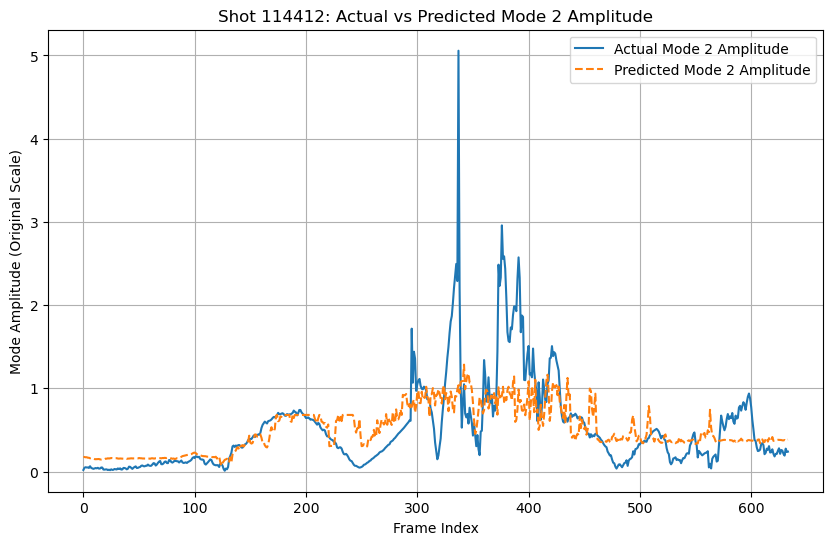

Shot 114412 - Mean absolute percentage error: 22.10%
Shot 114412 - Max actual amplitude: 5.06
Shot 114412 - Max predicted amplitude: 1.28


In [29]:
def plot_reserved_shot_predictions(shot, shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, model, ma_norm):
    """Plot actual vs predicted Mode 2 amplitude for the reserved shot."""
    if shot not in valid_shots:
        print(f"Reserved shot {shot} is not valid. No plot generated.")
        return
    
    shot_idx = shot_list.index(shot)
    valid_idx = valid_shots.index(shot)
    camera_data = cut_training_data_2D[valid_idx]
    hbt_data = hbt_ma2_data[valid_idx][:, 0]
    
    if len(camera_data) == 0:
        print(f"No camera data for shot {shot}. No plot generated.")
        return
    
    # Prepare camera data for prediction
    input_data = np.array(camera_data).reshape(-1, 32, 32, 1)
    predictions = model.predict(input_data, verbose=0)[:, 0] * ma_norm  # Scale back to original units
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.plot(hbt_data, label='Actual Mode 2 Amplitude')
    plt.plot(predictions, '--', label='Predicted Mode 2 Amplitude')
    plt.xlabel('Frame Index')
    plt.ylabel('Mode Amplitude (Original Scale)')
    plt.title(f'Shot {shot}: Actual vs Predicted Mode 2 Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    prediction_errors = np.abs(hbt_data - predictions) / ma_norm * 100
    print(f"Shot {shot} - Mean absolute percentage error: {np.mean(prediction_errors):.2f}%")
    print(f"Shot {shot} - Max actual amplitude: {np.max(np.abs(hbt_data)):.2f}")
    print(f"Shot {shot} - Max predicted amplitude: {np.max(np.abs(predictions)):.2f}")

# Plot predictions for the reserved shot
plot_reserved_shot_predictions(
    RESERVED_SHOT, shot_list, valid_shots, cut_training_data_2D, hbt_ma2_data, william_model, ma_norm
)